# Spatial biases

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn
import math
import os
import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

dask.config.set(scheduler="single-threaded")

In [3]:
def traverseDir(root):
    for (dirpath, dirnames, filenames) in os.walk(root):
        for file in filenames:
            if file.endswith(('.nc')):
                yield os.path.join(dirpath, file)

In [4]:
import intake
import pandas as pd

def open_catalog(url=None):
    """
    Open a data catalog from a given URL. If no URL is provided, use the default URL.

    Parameters:
    url (str, optional): The URL of the data catalog. Defaults to None.

    Returns:
    intake.catalog: The opened data catalog.
    """
    if url is None:
        url = "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/joint-evaluation/CORDEX-CMIP6.json"
    return intake.open_esm_datastore(url)

def get_source_collection(
    variable_id,
    frequency,
    driving_source_id="ERA5",
    add_fx=None,
    catalog=None,
    **kwargs,
):
    """
    Search the catalog for datasets matching the specified variable_id, frequency, and driving_source_id.

    Parameters:
    variable_id (str): The variable ID to search for.
    frequency (str): The frequency to search for.
    driving_source_id (str, optional): The driving source ID to search for. Defaults to "ERA5".
    add_fx (bool, optional): Whether to add fixed variables. Defaults to False.
    catalog (intake.catalog, optional): The data catalog to search in. If None, open the default catalog.

    Returns:
    intake.catalog: The filtered data catalog.
    """
    if add_fx is None:
        add_fx = "areacella"
    if catalog is None:
        catalog = open_catalog()
    subset = catalog.search(
        variable_id=variable_id,
        frequency=frequency,
        driving_source_id=driving_source_id,
        require_all_on=["source_id"],
        **kwargs,
    )
    source_ids = list(subset.df.source_id.unique())
    print(f"Found: {source_ids} for variables: {variable_id}")
    if add_fx:
        if add_fx is True:
            fx = catalog.search(source_id=source_ids, frequency="fx", **kwargs)
        else:
            fx = catalog.search(
                source_id=source_ids, frequency="fx", variable_id=add_fx, **kwargs)
            if fx.df.empty:
                warn(f"static variables not found: {variable_id}")
        subset.esmcat._df = pd.concat([subset.df, fx.df])
    return subset

In [5]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40041 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41473' processes=16 threads=16, memory=125.79 GiB>

In [6]:
vertices = {'CMIP6': ("vertices_lon", "vertices_lat"),
            'CMIP5': ("lon_vertices", "lat_vertices")}

def add_bounds(ds, mip_era = 'CMIP6'):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=vertices[mip_era])
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
            ),
        )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        source = [ds.attrs[attr] for attr in ['source_id', 'model_id', 'source'] if attr in ds.attrs]
        warn(f"sftlf not found in dataset: {source[0]}")
    return ds


def open_datasets(variables, frequency="mon", driving_source_id="ERA5", 
                  mask=True, add_missing_bounds=False, **kargs):
    catalog = get_source_collection(variables, frequency, driving_source_id,
                                    add_fx=["areacella", "sftlf"])
    dsets = open_and_sort(catalog, merge=merge, concat=False, 
                          time_range = kargs.get("time_range", None))
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            if driving_source_id == 'ERA5':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP6')
            elif driving_source_id == 'ERAINT':
                dsets[dset_id] = add_bounds(ds, mip_era='CMIP5')                
    return dsets

def create_cordex_grid(domain_id, mip_era = 'CMIP6'):
    grid = cx.domain(domain_id, bounds=True, mip_era=mip_era)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            #continue
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid

def regrid_dsets(dsets, target_grid, method="bilinear"):
    dsets_interp = {}
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except Exception as e:
            print(f"problems with grid_mapping definition {dset_id}")
            continue
        if mapping == "rotated_latitude_longitude":
            dsets_interp[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets_interp[dset_id] = regrid(ds, regridder)
    return dsets_interp
    
def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [7]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [8]:
def standardize_unit(ds, variable):
    if variable == 'tas':
        ds = convert_celsius_to_kelvin(ds)
    elif variable == 'pr':
        ds = convert_precipitation_to_mm(ds)
    return ds
    
def convert_celsius_to_kelvin(ds, threshold=200):
    """
    Converts all temperature variables in an xarray Dataset from degrees Celsius to Kelvin
    based on the 'units' attribute, value magnitude, or 'standard_name' attribute.

    Parameters:
        ds (xarray.Dataset): The input dataset.
        threshold (float): A heuristic threshold (default=200) to assume temperatures 
                           below this value might be in Celsius.

    Returns:
        xarray.Dataset: A new dataset with converted temperature values.
    """
    ds = ds.copy()  # Avoid modifying the original dataset

    for var in ds.data_vars:
        units = ds[var].attrs.get("units", "").lower()
        standard_name = ds[var].attrs.get("standard_name", "").lower()

        # Check if units explicitly indicate Celsius
        if units in ["c", "°c", "celsius", "degc"]:
            ds[var] = ds[var] + 273.15 
            ds[var].attrs["units"] = "K"
            print(f"Convert celsius to kelvin")
        
        # If no unit attribute exists, check standard_name for temperature-related terms
        elif standard_name in ["air_temperature", "sea_surface_temperature", "surface_temperature"]:
            data_vals = ds[var].values
            if np.nanmax(data_vals) < threshold:  # Likely in °C
                ds[var] = ds[var] + 273.15
                ds[var].attrs["units"] = "K"
                print(f"Convert celsius to kelvin")
                
    return ds

def convert_precipitation_to_mm(ds):
    """
    Converts all precipitation variables in an xarray Dataset to millimeters (mm)
    based on the 'units' attribute or 'standard_name' attribute.

    Parameters:
        ds (xarray.Dataset): The input dataset.

    Returns:
        xarray.Dataset: A new dataset with converted precipitation values.
    """
    ds = ds.copy()  # Avoid modifying the original dataset

    for var in ds.data_vars:
        units = ds[var].attrs.get("units", "").lower()
        standard_name = ds[var].attrs.get("standard_name", "").lower()

        # Check if units explicitly indicate meters (m) or kilograms per meter per second squared (kg/m/s²)
        if units in ["m", "meters"]:
            ds[var] = ds[var] * 1000  # Convert from meters to millimeters
            ds[var].attrs["units"] = "mm"
            print(f"Convert precipitation from meters to millimeters (mm).")
        
        elif units in ["kg m-2 s-1", "kg/m/s2"]:
            # Precipitation rate in kg/m/s² can be converted to mm/s by multiplying by 1000
            ds[var] = ds[var] * 86400  # Convert kg/m/s² to mm/s
            ds[var].attrs["units"] = "mm"
            print(f"Convert precipitation from kg/m/s² to mm/s.")
                
    return ds

In [9]:
def check_equal_period(ds, period):
    years_in_ds = np.unique(ds.time.dt.year.values)
    expected_years = np.arange(int(period.start), int(period.stop)+1) 
    return np.array_equal(years_in_ds, expected_years)

In [10]:
def fix_360_longitudes(
    dataset: xr.Dataset, lonname: str = "lon"
) -> xr.Dataset:
    """
    Fix longitude values.

    Function to transform datasets where longitudes are in (0, 360) to (-180, 180).

    Parameters
    ----------
    dataset (xarray.Dataset): data stored by dimensions
    lonname (str): name of the longitude dimension

    Returns
    -------
    dataset (xarray.Dataset): data with the new longitudes
    """
    lon = dataset[lonname]
    if lon.max().values > 180 and lon.min().values >= 0:
        dataset[lonname] = dataset[lonname].where(lon <= 180, other=lon - 360)
    return dataset

In [11]:
default_attrs_ = [
        "project_id",
        "domain_id",
        "institution_id",
        "driving_source_id",
        "driving_experiment_id",
        "driving_variant_label",
        "source_id",
        "version_realization",
        'frequency',
        'variable_id',
        "version"
]

In [12]:
var_dic = {
    'tas': {'variable': 'tas', 'name': 'Temperature BIAS [K]', 
            'diff': 'abs', 'aggr': 'mean', 
            'levels': np.arange(-5, 6, 1), 'cmap' : "RdBu_r",
            'units': "C", "datasets": ["era5", "cerra"]},
    'pr': {'variable': 'pr', 'name': 'Precipitation BIAS [%]', 
           'diff': 'rel', 'aggr': 'mean',
            'levels': np.arange(-100, 110, 10), 'cmap' : "BrBG",
            'units': '%', "datasets": ["era5", "cerra-land"]},
    'psl': {'variable': 'psl', 'name': 'Sea-level pressure BIAS [hp]', 
           'diff': 'rel', 'aggr': 'mean',
            'levels': np.arange(-6, 7, 1), 'cmap' : "RdBu_r",
            'units': 'hpa', "datasets": ["era5", "cerra"]}
}

In [31]:
variable = 'pr'
frequency = 'mon'
domain = "EUR-11"
regridding = "bilinear"
period = slice("1989", "2008")

In [32]:
save_results_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'intermediate-results'))
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'plots'))

In [33]:
rotated_grid = create_cordex_grid('EUR-11', mip_era='CMIP5')# No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [34]:
# load, regrid and calculate seasonal means
eobs = obs.eobs(variable, add_mask=False).sel(time=period)
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
#eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.47 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


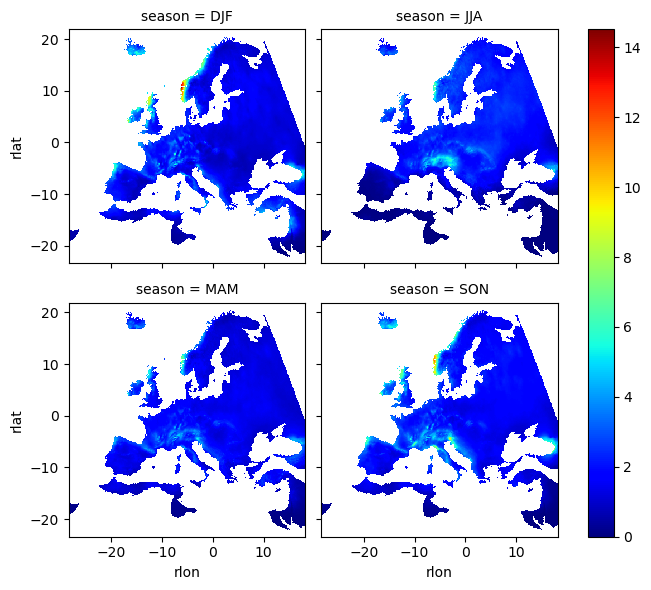

In [35]:
ref_seasmean.plot(col="season", col_wrap=2, cmap = 'jet')

## CERRA and ERA5

In [36]:
variable_mapping = {
    'cerra': {
        'tas': 't2m',
        'pr': 'tp'
    },
    'cerra-land': {
        'tas': 'tas',
        'pr': 'tp'
    },
    'era5': {
        'tas': 't2m',
        'pr': 'tp'
    }
}
def load_obs(variable, dataset, add_mask=False):
    root = f"/mnt/CORDEX_CMIP6_tmp/aux_data/{dataset}/mon/{variable}/"
    ds = xr.open_mfdataset(np.sort(list(traverseDir(root))), 
                           concat_dim='valid_time', combine='nested')
    ds = ds.rename({'valid_time': "time"})
    return ds

In [37]:
dsets = {}
for dset in var_dic[variable]['datasets']:
    ds = load_obs(variable, dset)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname = 'longitude')
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]:variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

Convert precipitation from meters to millimeters (mm).


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 18.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [38]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [39]:
for dset, ds  in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=False)
    dsets[dset] = regridder(ds)

In [40]:
if var_dic[variable]['diff'] == 'abs':
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
elif var_dic[variable]['diff'] == 'rel':
    diffs = {
        dset_id: 100*(seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))/(ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

# CMIP6

In [82]:
mip_era = 'CMIP6'
driving_source_id = 'ERA5'
# Define how to merge the files in xarray
merge = ["variable_id", "frequency"]
default_attrs = [d for d in default_attrs_ if not d in merge]

In [83]:
dsets = open_datasets([variable], frequency=frequency, driving_source_id = driving_source_id,
                     mask=True, add_missing_bounds=False, 
                      **{'merge': merge, 'time_range': period})

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


2025-04-21 11:39:20,651 - distributed.worker - ERROR - Compute Failed
Key:       _open_dataset-6366105a-16b1-4bd5-a1f9-0bd84d9c6d9e
State:     executing
Task:  <Task '_open_dataset-6366105a-16b1-4bd5-a1f9-0bd84d9c6d9e' apply(...)>
Exception: "FileNotFoundError(2, 'No such file or directory')"
Traceback: '  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/dask/utils.py", line 77, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py", line 66, in _open_dataset\n    url = fsspec.open_local(urlpath, **storage_options)\n          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/fsspec/core.py", line 533, in open_local\n    with of as files:\n         ^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsi

ESMDataSourceError: Failed to load dataset with key='CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.fx.v20241120'
                 You can use `cat['CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.fx.v20241120'].df` to inspect the assets/files for this key.
                 

In [ ]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [ ]:
for dset in dsets.keys():
    dsets[dset] = convert_celsius_to_kelvin(dsets[dset])

In [ ]:
rotated_grid = create_cordex_grid(domain, mip_era=mip_era)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

In [ ]:
if var_dic[variable]['diff'] == 'abs':
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
elif var_dic[variable]['diff'] == 'rel':
    diffs = {
        dset_id: 100*(seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))/(ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id"], default_attrs = default_attrs), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [ ]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_spatial_bias.nc")

# CMIP5

In [ ]:
mip_era = 'CMIP5'
driving_source_id = 'ERAINT'
# Define how to merge the files in xarray
merge = ["variable_id", "frequency", "driving_variant_label", "version"]
default_attrs = [d for d in default_attrs_ if not d in merge]

In [32]:
dsets = open_datasets([variable], frequency=frequency, driving_source_id = driving_source_id,
                     mask=True, add_missing_bounds=False, 
                      **{'merge': merge, 'time_range': period})

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


2025-04-21 10:53:53,758 - distributed.worker - ERROR - Compute Failed
Key:       _open_dataset-fac053b7-7856-43a0-bfc9-54070139372f
State:     executing
Task:  <Task '_open_dataset-fac053b7-7856-43a0-bfc9-54070139372f' apply(...)>
Exception: "FileNotFoundError(2, 'No such file or directory')"
Traceback: '  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/dask/utils.py", line 77, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py", line 66, in _open_dataset\n    url = fsspec.open_local(urlpath, **storage_options)\n          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/fsspec/core.py", line 533, in open_local\n    with of as files:\n         ^^\n  File "/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsi

ESMDataSourceError: Failed to load dataset with key='CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.fx.v20241120'
                 You can use `cat['CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.fx.v20241120'].df` to inspect the assets/files for this key.
                 

In [ ]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [ ]:
for dset in dsets.keys():
    dsets[dset] = convert_celsius_to_kelvin(dsets[dset])

In [ ]:
rotated_grid = create_cordex_grid(domain, mip_era=mip_era)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

In [ ]:
if var_dic[variable]['diff'] == 'abs':
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
elif var_dic[variable]['diff'] == 'rel':
    diffs = {
        dset_id: 100*(seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))/(ref_seasmean)
        for dset_id, ds in dsets.items() if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: short_iid(x, ["source_id"], default_attrs = default_attrs), diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [ ]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_spatial_bias.nc")

# Plot

In [41]:
CMIP6_seasonal_bias = xr.open_dataset(f"{save_results_path}/{variable}_CMIP6_spatial_bias.nc")
CMIP5_seasonal_bias = xr.open_dataset(f"{save_results_path}/{variable}_CMIP5_spatial_bias.nc")

In [42]:
eur_colors = pd.read_csv('eurocordex_models.csv')

In [43]:
projects = ['CMIP5', 'CMIP6']
models_cmip6 = eur_colors[eur_colors["mip_era"] == 'CMIP6']['model'].values
parents_cmip6 = eur_colors[eur_colors["mip_era"] == 'CMIP6']['parent'].values
parents_cmip6[eur_colors[eur_colors["mip_era"] == 'CMIP6']['parent_mip_era'] == 'CMIP6'] = np.nan

In [44]:
models = []
for m5, m6 in zip(parents_cmip6, models_cmip6):
    models.append(f"cmip5_{m5}")
    models.append(f"cmip6_{m6}")

In [45]:
models = [m for m in models if not '_nan' in m]

In [46]:
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [47]:
models = obs_seasonal_bias.dset_id.values.tolist() + models

/tmp/ipykernel_1030427/3892889989.py:2: FutureWarning: This is a FutureWarning example
  warnings.warn("This is a FutureWarning example", FutureWarning)
/tmp/ipykernel_1030427/3892889989.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_1030427/3892889989.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_1030427/3892889989.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_1030427/3892889989.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)


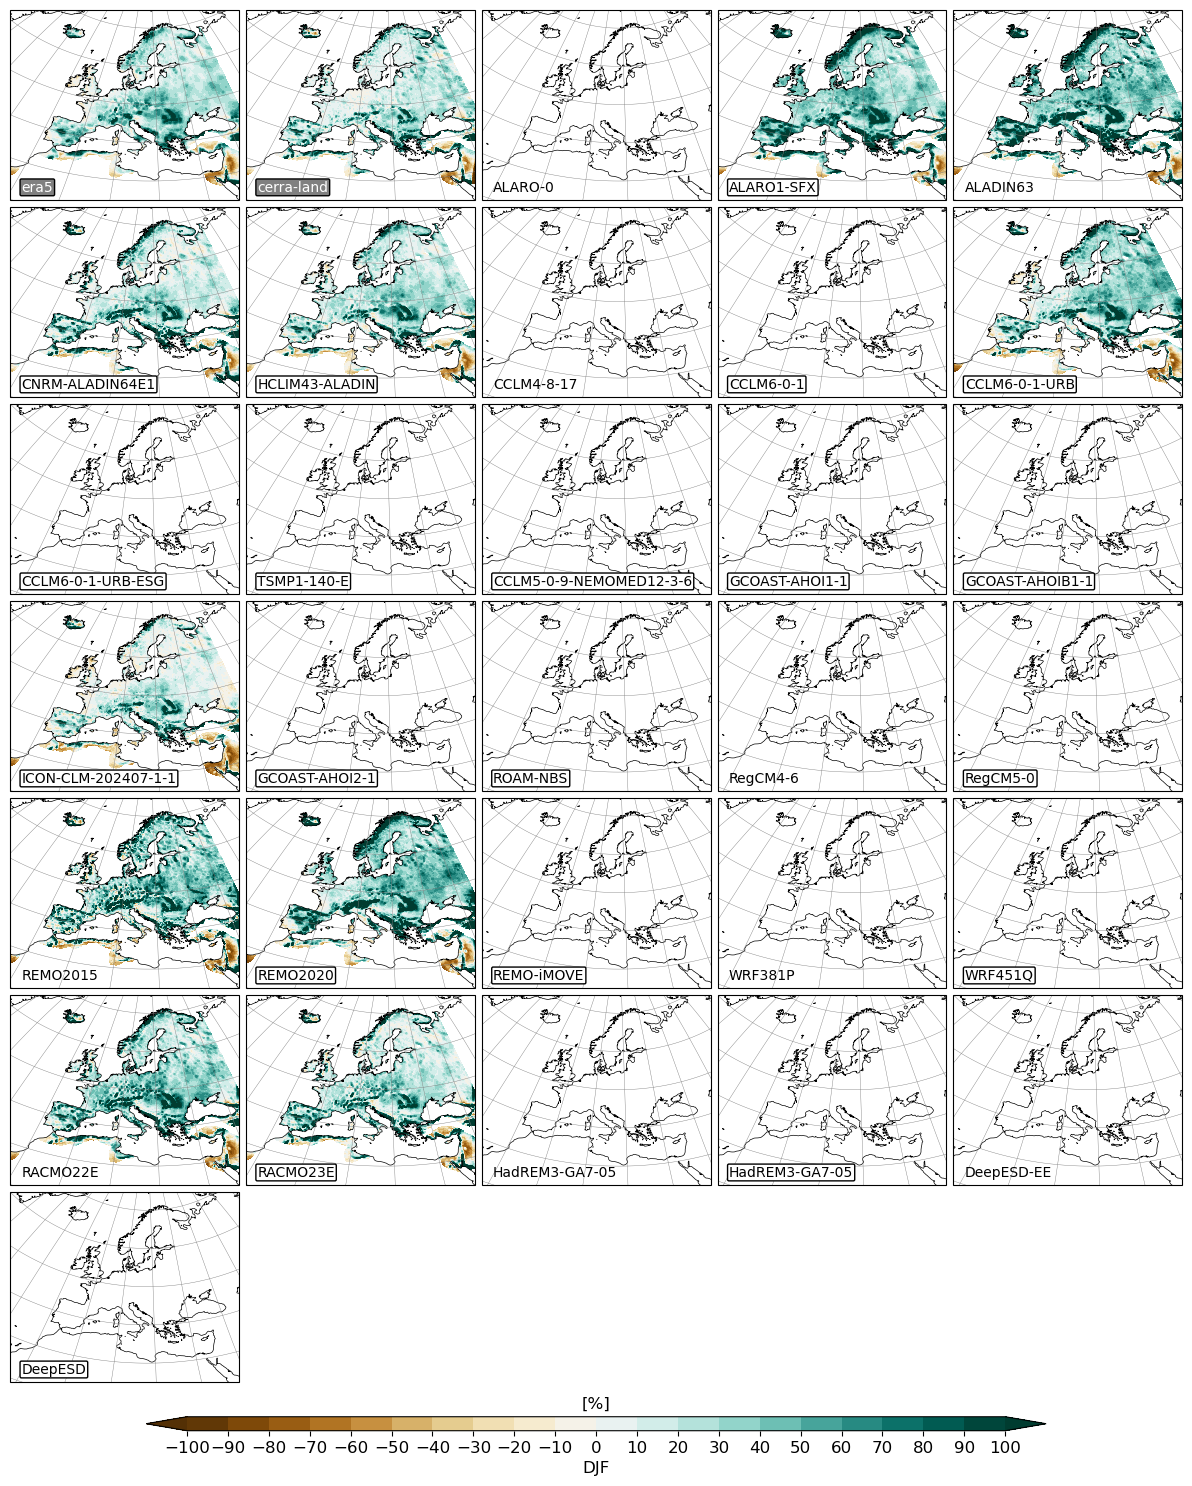

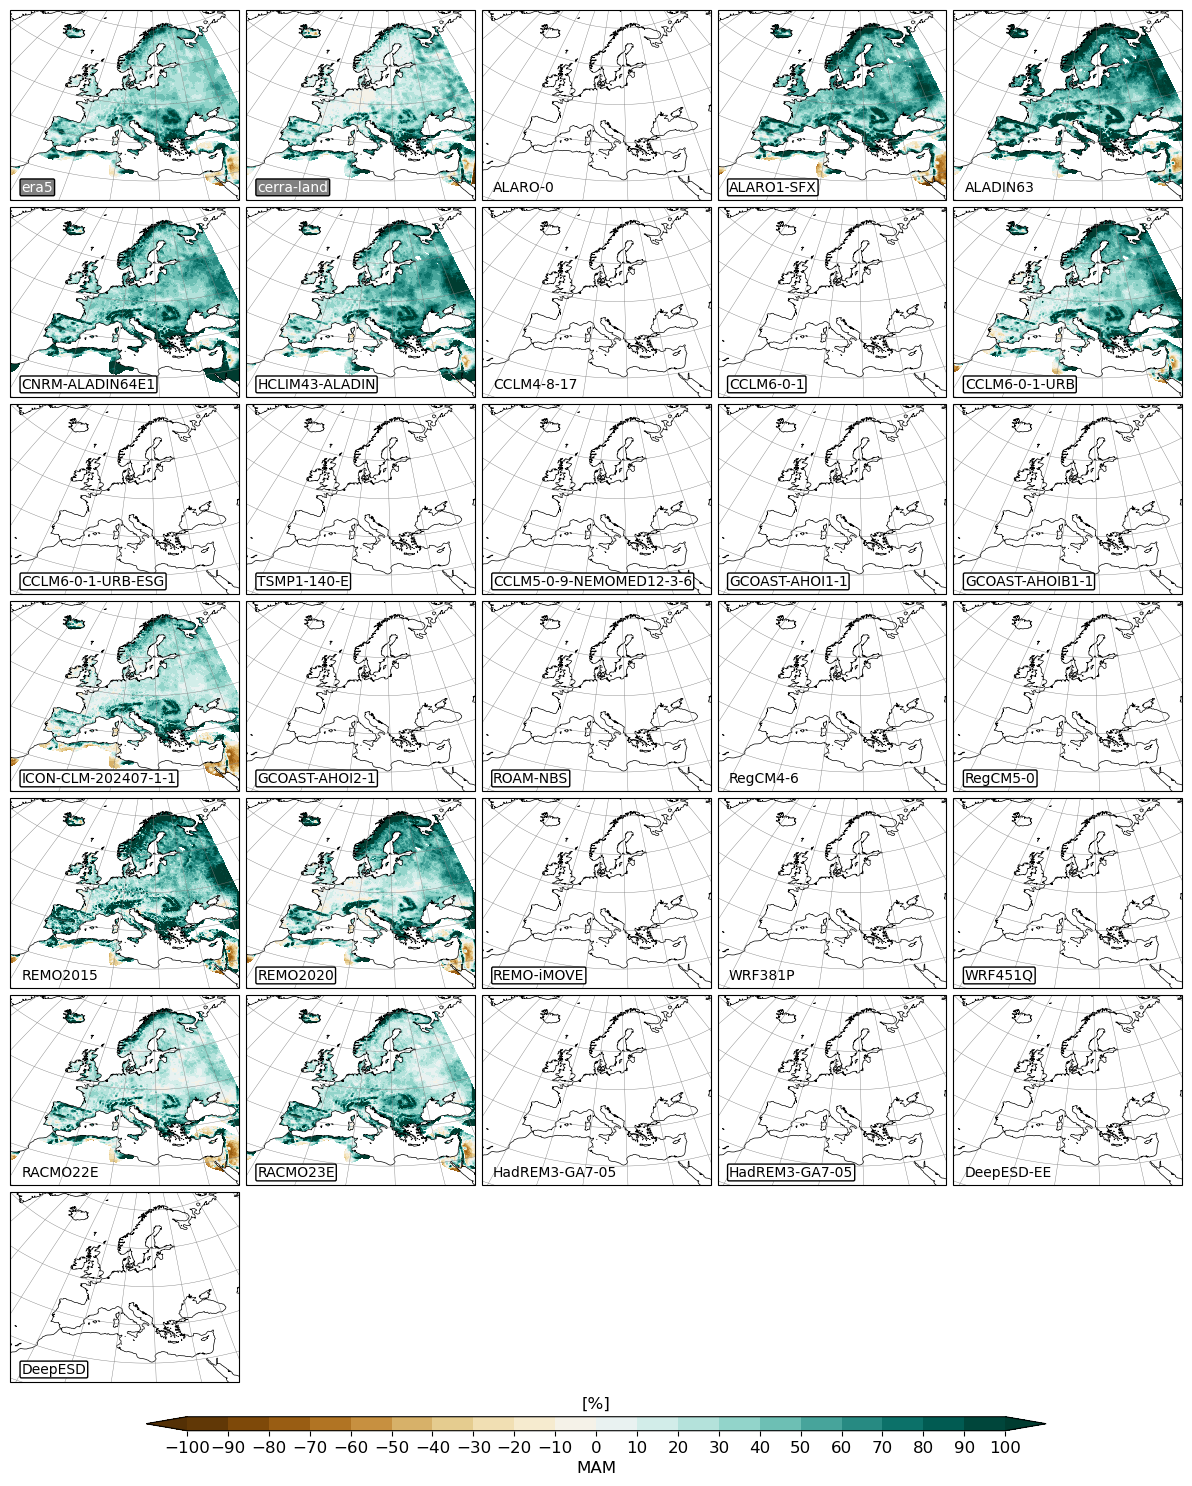

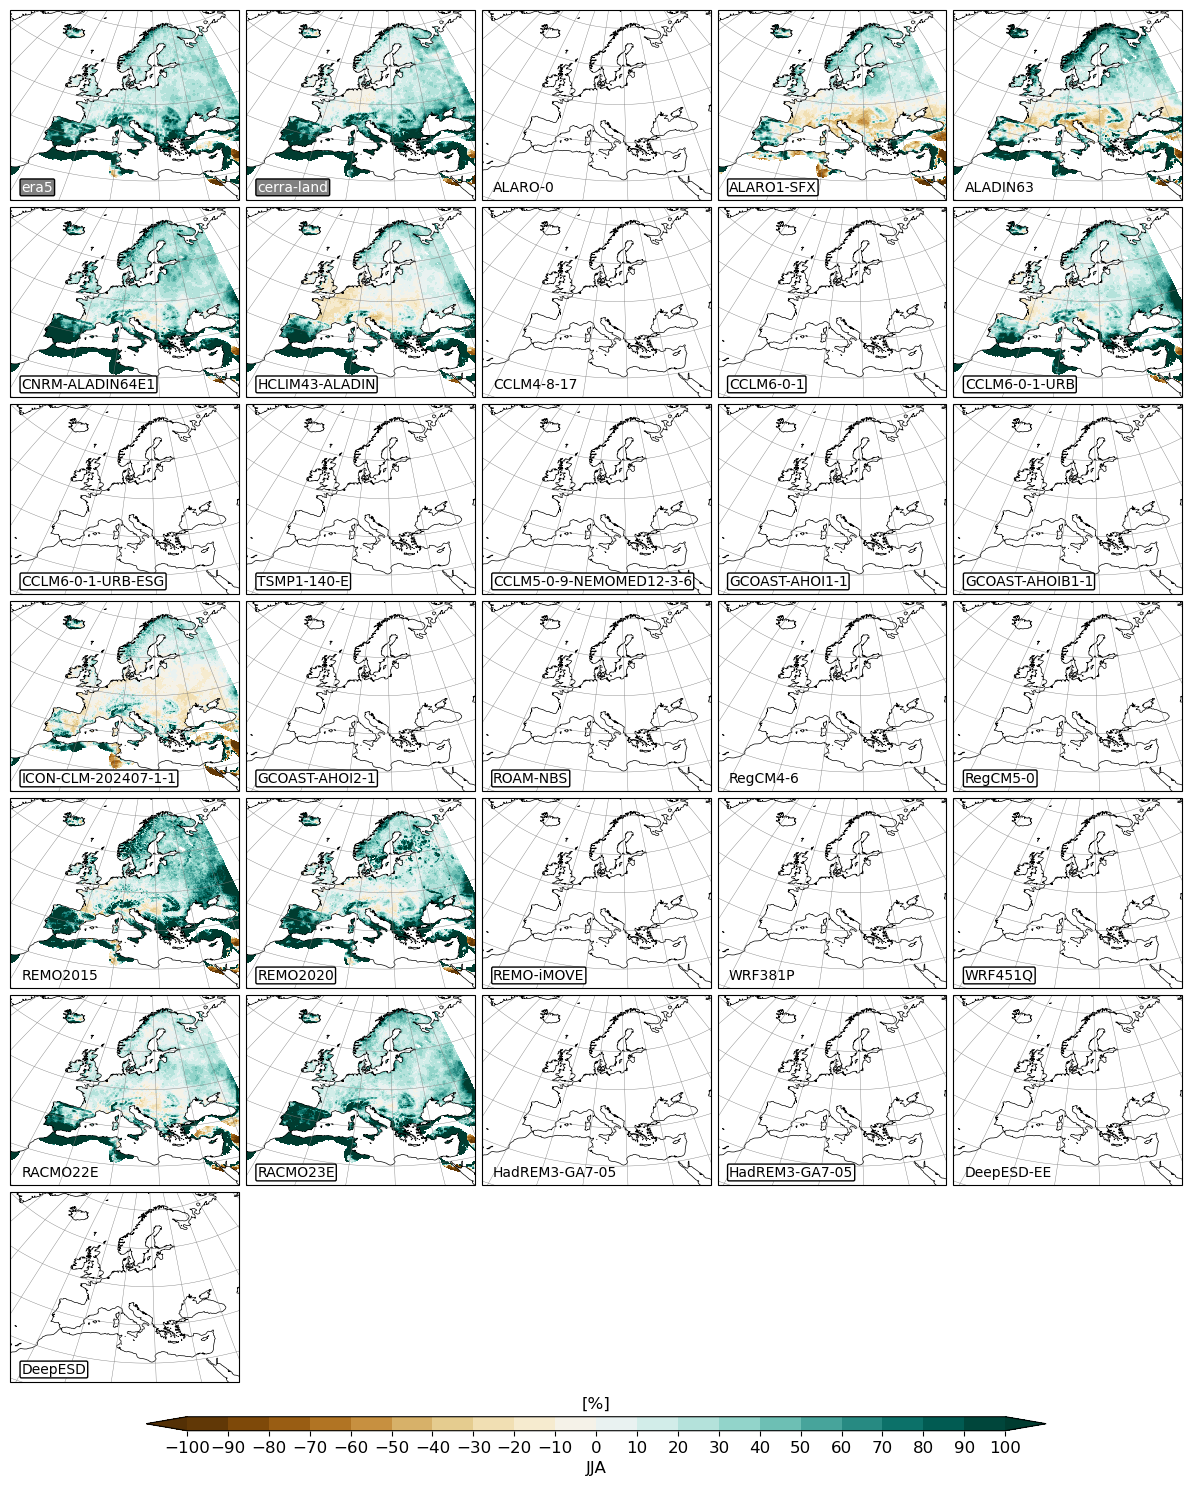

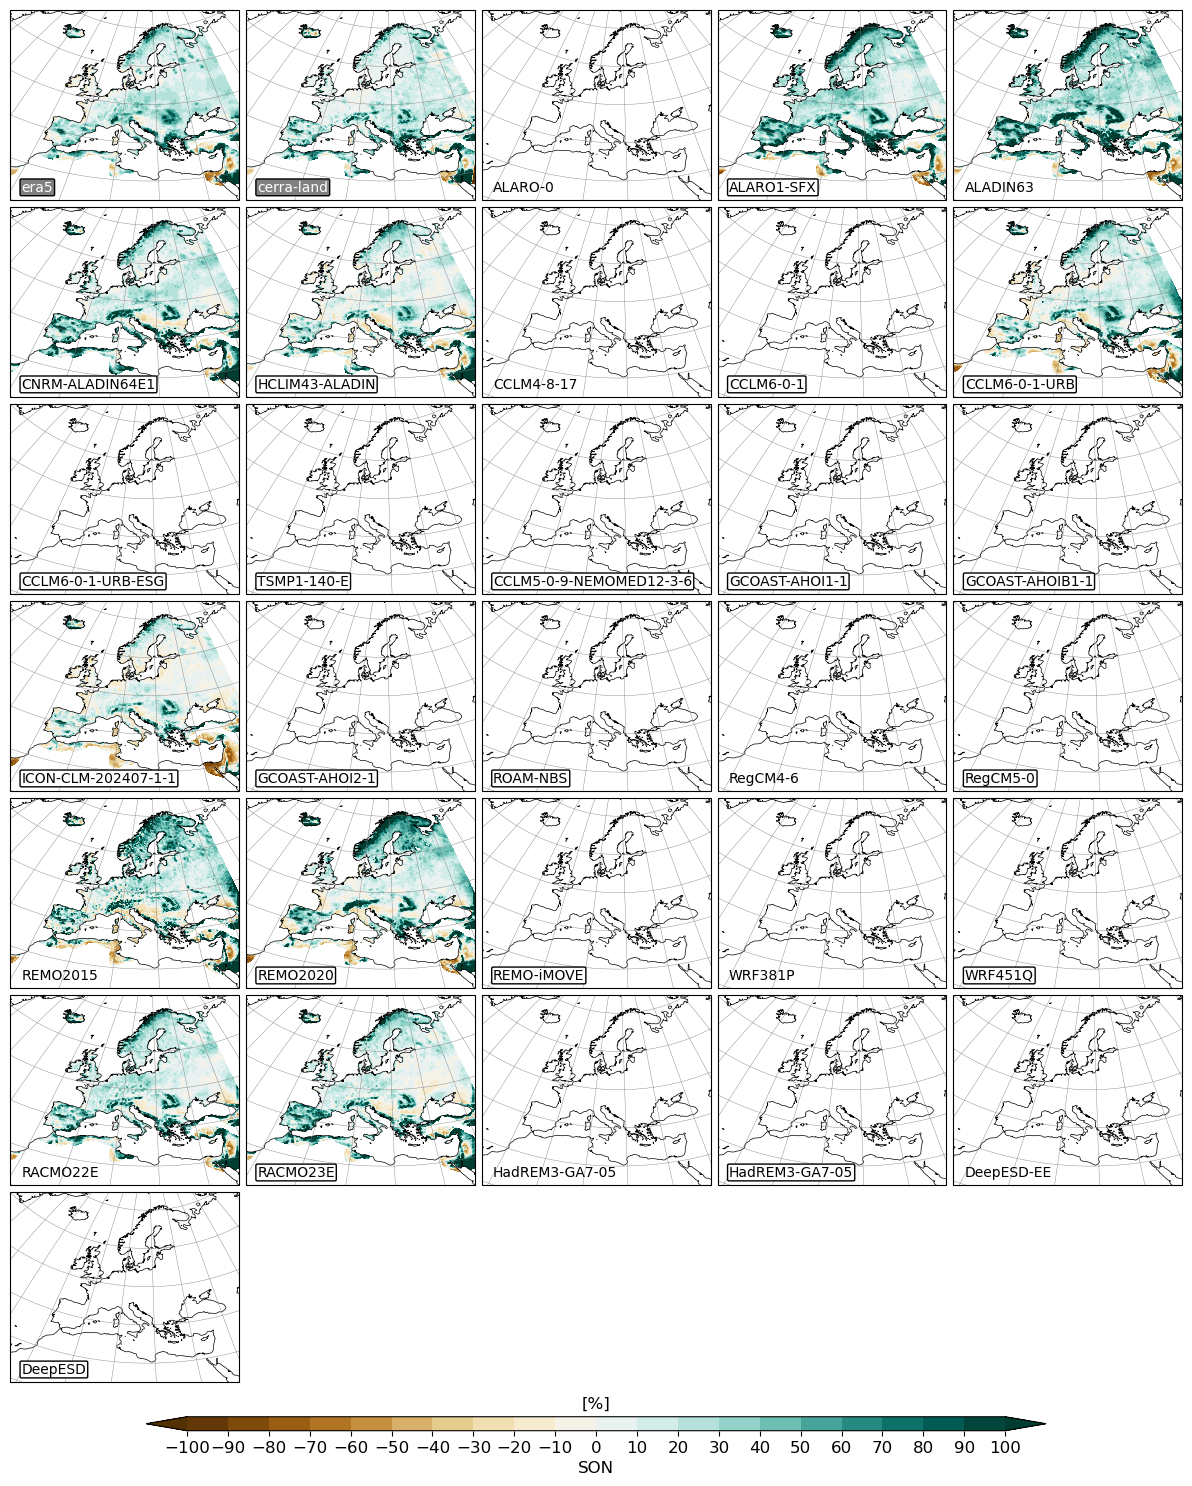

In [48]:
import warnings
warnings.warn("This is a FutureWarning example", FutureWarning)

for season in ["DJF", "MAM", "JJA", "SON"]:
    
    ncols = 5
    nrows = math.ceil(len(models)/ncols)
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform
    
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(12, 14),
    )

    axs = axs.flatten()
    
    for n_m, model in enumerate(models):

        if 'cmip5' in model:
            ds = CMIP5_seasonal_bias
            project = 'cmip5'
            model = model.split(project + '_')[1]
        elif 'cmip6' in model:
            ds = CMIP6_seasonal_bias
            project = 'cmip6'
            model = model.split(project + '_')[1]
        else:
            ds = obs_seasonal_bias
            project = 'obs'

        aspect = ds.cf.sizes["Y"] / ds.cf.sizes["X"]

        if project == 'obs':
            data = ds[variable].isel(
                season=np.where(ds.season == season)[0],
                dset_id=np.where(ds.dset_id == model)[0]).squeeze(dim=["season", "dset_id"])

        elif model in ds.dset_id:
            data = ds[variable].isel(
                season=np.where(ds.season == season)[0],
                dset_id=np.where(ds.dset_id == model)[0]).squeeze(dim=["season", "dset_id"])
        else:
            data = ds[variable].isel(
                season=np.where(ds.season == season)[0],
                dset_id=0).squeeze(dim=["season"])*np.nan

        cs = axs[n_m].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            levels=var_dic[variable]['levels'],
            extend="both",
            cmap=var_dic[variable]['cmap'])

        axs[n_m].set_aspect(round(aspect, 3))
        axs[n_m].coastlines(resolution="50m", color="black", linewidth=0.5)
        
        gl = axs[n_m].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )
    
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[n_m].xaxis.set_major_formatter(lon_formatter)
        axs[n_m].yaxis.set_major_formatter(lat_formatter)

        if project == 'cmip6':
            axs[n_m].set_title(model, loc='left', y = 0, x = 0.05,
                               fontsize=10, 
                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
        elif project == 'cmip5':
            axs[n_m].set_title(model, loc='left', y = 0, x = 0.05,
                               fontsize=10)
        elif project == 'obs':
            axs[n_m].set_title(model, loc='left', y = 0, x = 0.05,
                               fontsize=10, 
                               color= 'white',
                               bbox=dict(facecolor='grey', edgecolor='black', boxstyle='round,pad=0.1'))
      
    cbar_ax = fig.add_axes([0.125, -0.025, 0.75, 0.01]) 
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", ticks=var_dic[variable]['levels'])
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]", fontsize = 12)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(season, fontsize = 12)
        
    for ax in axs[len(models):]: 
        ax.remove()

    for ax in axs:
        ax.set_aspect('auto')

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
       
    plt.savefig(f"{save_figure_path}/CMIP6-parents_eobs_{variable}_{season}_{period.start}-{period.stop}.png", bbox_inches='tight')        